# Selection of the best optimizer

## Contents
* [Task description](#Task-description)
* [The parameters studied](#The-parameters-studied)
* [Parameters Value Area](#Parameters-Value-Area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Creating a model template](#Creating-a-model-template)
* [Staged hyperparameters search](##Staged-hyperparameters-search)
* [Results](#Results)
* [Conclusion](#Conclusion)


## Task description

To choose optimizer hyperparameters for a CNN which classifies MNIST.
The selection criterion is the convergence rate of the loss function.

## The parameters studied
learning rate, momentum в tf.train.MomentumOptimizer

## Parameters Value Area
learning_rate: {1e-4, 1e-3, 1e-2, 1e-1, 1}

momentum: {0.5, 0.9, 0.99}

## Metrics

Value of loss function

In [1]:
import os
import sys
sys.path.insert(0, os.path.join("..", ".."))

In [2]:
import numpy as np

from batchflow import Pipeline, B, V, C
from batchflow.opensets import MNIST

from batchflow.research import Option, Research, Results
from batchflow.models.tf import TFModel

from src import get_accuracy, show_research, save_model

%matplotlib inline

## Dataset loading
Dataset loading

In [3]:
mnist_set = MNIST()

Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


Dataset bypass:

- Define a root pipeline that will be shared between different model configurations
- Define batch size (64), fix a dataset bypass by fixing the seed.

In [4]:
BATCH_SIZE = 64

In [5]:
train_root = (Pipeline()
                .run_later(BATCH_SIZE, shuffle=123, n_epochs=None) << mnist_set.train)
              
test_root = (Pipeline()
                .run_later(BATCH_SIZE, shuffle=123, n_epochs=1) << mnist_set.test)

*In our case, train_root and test_root only generate a batch of data that will be passed to the training and test pipeline, but if you do, for example, random augmentations, then they should also be defined here. In addition to bringing the compared models under equal conditions, this will also be useful in the case where the data takes up a large amount of memory, thus, a heavy data loading operation is performed once for several models. *

## Creating a model template

We create a small CNN architecture passing layers' parameters to `model_config`.
The parameters that will vary are defined as `C('parameter_name')`.

We use `Momentum Optimizer` (tf.train.MomentumOptimizer) with parameter `use_nesterov=True`.

In [6]:
NUM_CLASSES = 10

In [7]:
model_config = {
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': NUM_CLASSES,
    'initial_block/inputs': 'images',    
    'body': dict(layout='cpna cpna cpna', filters=[64, 128, 256],
                 strides=2, pool_strides=1, kernel_size=3),
    'head': dict(layout='Pf', units=NUM_CLASSES),
    'loss': 'cross-entropy',
    'optimizer': ("Momentum", {'use_nesterov':True, 'learning_rate':
                               C('lr'), 'momentum': C('mu')})}

Create training and test pipeline.

In [8]:
train_template = (Pipeline()
                  .init_variable('loss', init_on_each_run=list)
                  .init_variable('accuracy', init_on_each_run=list)
                  .init_model('dynamic', TFModel, 'mnist_model', config=model_config)
                  .to_array()
                  .train_model('mnist_model',
                               images=B('images'), labels=B('labels'),
                               fetches='loss', save_to=V('loss', mode='w')))

test_template = (Pipeline()
                 .import_model('mnist_model', C('import_from'))
                 .init_variable('loss', init_on_each_run=list)
                 .init_variable('predictions', init_on_each_run=list)
                 .init_variable('metrics', init_on_each_run=None)
                 .to_array()
                 .predict_model('mnist_model', images=B('images'),
                                fetches=['loss', 'predictions'],
                                save_to=[V('loss'), V('predictions')])
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                 fmt='logits', axis=-1, save_to=V('metrics', mode='u')))

## Staged hyperparameters search

Set the parameters for `research` execution:

If you can afford to run a hyperparameters search across the entire grid of values `[1e-4, 1e-3, 1e-2, 1e-1, 1]) * [0.5, 0.9, 0.99]` then it is probably worth doing.

However, in practice, in conditions of limited resources, it is reasonable to split the search into stages.
* to first search in coarse ranges or search for a parameter that has a greater effect on convergence (in our case, this is learning rate).

* fine stage - search for a more detailed grid and setting a minor parameter (in our case, the momentum value)

For each parameter set perform NUM_ITERS=200 iterations of train pipeline with model performance evaluation every 20 iterations. Repeat this procedure NUM_REPEAT=2 times.

### 1. Coarse stage
### The learning rate search

In [9]:
op1 = Option('lr', [1e-4, 1e-3, 1e-2, 1e-1, 1])
op2 = Option('mu', [0.5])
grid = op1 * op2

research = (Research()
            .add_pipeline(root=train_root, branch=train_template, variables='loss', name='train')
            .add_pipeline(root=test_root, branch=test_template,  variables='loss', name='test',
                          execute='%20', run=True, import_from='train')
            .add_grid(grid))

In [10]:
NUM_REPEAT = 2
NUM_ITERS = 200
research_name = 'lr_research'

Execute research

In [11]:
research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name=research_name, bar=True)

Research lr_research is starting...


  0%|          | 0/2000 [00:00<?, ?it/s]

Distributor has 10 jobs with 200 iterations. Totally: 2000


100%|██████████| 2000/2000 [08:28<00:00,  3.93it/s]


The working time on a grid of size 5 and 2 starts, with 200 iterations of each model is 8 minutes 28 seconds on the Tesla K80

Let's look at the results, smoothing the loss and test_loss by 20 observations.

It may be convenient to look at the graphs of the loss function in a logarithmic scale.

### Analysis of research results

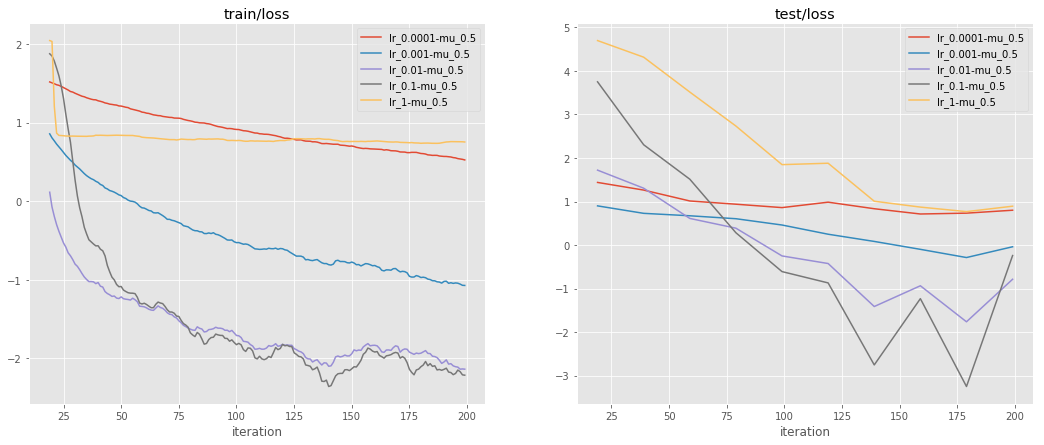

In [12]:
research = Results(path=research_name).load(use_alias=True)
show_research(research, average_repetitions=True, log_scale=[True, True],
              layout=['train/loss', 'test/loss'], rolling_window=[20, None])

You can see that for this model configuration, the `Momentum` optimizer converges best with  $lr \in \{0.1^2, 0.1\}$, therefore we will use these two when searching for momentum value.

### 2. Fine stage
### Joint selection of a learning rate and momentum

In [13]:
NUM_REPEAT = 3
NUM_ITERS = 200
research_name = 'lr_mu_research'

In [14]:
op1 = Option('lr', [1e-2, 1e-1])
op2 = Option('mu', [0.5, 0.9, 0.99])
grid = op1 * op2

research = (Research()
            .add_pipeline(root=train_root, branch=train_template,
                      variables='loss', name='train')
            .add_pipeline(root=test_root, branch=test_template,
                          variables='loss', name='test',
                          execute='%20', run=True, import_from='train')
            .add_grid(grid))

In [15]:
research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name=research_name, bar=True)

Research lr_mu_research is starting...


  0%|          | 0/3600 [00:00<?, ?it/s]

Distributor has 18 jobs with 200 iterations. Totally: 3600


100%|██████████| 3600/3600 [15:29<00:00,  3.87it/s]


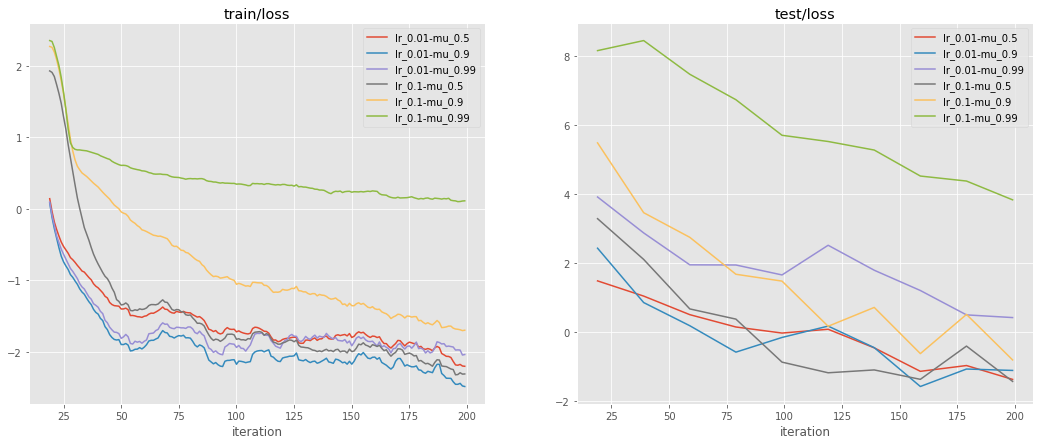

In [16]:
research = Results(path=research_name).load(use_alias=True)
show_research(research, average_repetitions=True, log_scale=[True, True],
              rolling_window=[20, None], layout=['train/loss', 'test/loss'])

So, running on a small number of iterations, we determined the parameters of the optimizer, at which the model converges most quickly. In our case, these are the parameters lr = 0.01, mu = 0.9 and mu = 0.5 and lr = 0.1, mu = 0.5, and the optimizer’s behavior on the test set is quite close, so it’s difficult to choose the best one at this stage.

Therefore, now let us launch research with these parameters for the entire training period (In this case, this is one epoch), saving additionally the accuracy value and the model at the end of training.

### 3. Final stage
Let's run research with final optimizer options, saving the models.

In [17]:
NUM_REPEAT = 1
NUM_ITERS = 1000
research_name = 'final_research'

In [18]:
grid = Option('lr', [1e-2]) * Option('mu', [0.5, 0.9]) + Option('lr', [1e-1]) * Option('mu', [0.5])

research = (Research()
            .add_pipeline(root=train_root, branch=train_template,
                          variables='loss', name='train')
            .add_pipeline(root=test_root, branch=test_template,
                          variables='loss', name='test',
                          execute='%50', run=True, import_from='train')
            .add_function(get_accuracy, returns='accuracy', name='test_accuracy',
                          execute='%50', pipeline='test')
            .add_function(save_model, execute=-1, pipeline='train',
                          model_name='mnist_model', path='saved_models/')
            .add_grid(grid))

In [19]:
research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name=research_name, bar=True)

Research final_research is starting...


  0%|          | 0/3000 [00:00<?, ?it/s]

Distributor has 3 jobs with 1000 iterations. Totally: 3000


100%|██████████| 3000/3000 [05:07<00:00,  9.77it/s]


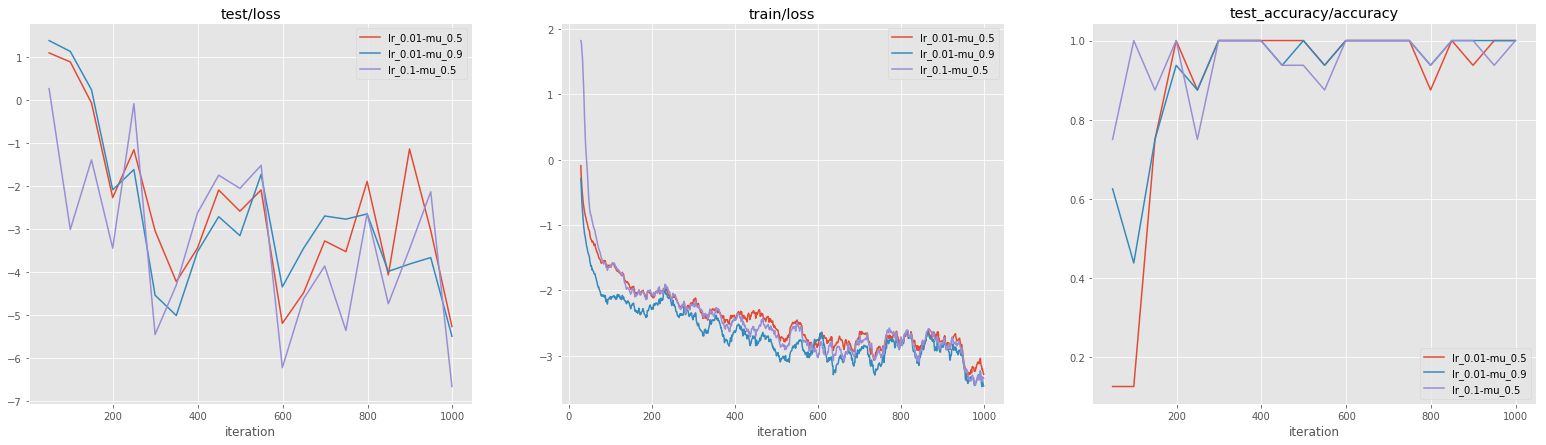

In [20]:
research = Results(path=research_name).load(use_alias=True)
show_research(research, average_repetitions=True, log_scale=[True, True, False],
              rolling_window=[None, 30, None],
              layout=['test/loss', 'train/loss', 'test_accuracy/accuracy'])

We see that loss graphs are very close, but in addition to the rate of convergence, another criterion for assessing the quality of the model that is also important to us — accuracy on the test set.
Since we saved the models to disk, compare their accuracy on the test set:

To do this, create a pipeline that loads the model from disk and computes the model predictions.

In [21]:
test_model_01_05 = (Pipeline()
                  .init_model('dynamic', TFModel, 
                             'mnist_model', 
                              config={'build': False,
                                      'load': {'path': 'saved_models/lr_0.1-mu_0.5_999/'}})
                  .init_variable('predictions', init_on_each_run=list)
                  .init_variable('metrics', init_on_each_run=None)
                  .to_array()
                  .predict_model('mnist_model', images=B('images'),
                                 fetches='predictions', save_to=V('predictions'))
                  .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                  fmt='logits', axis=-1,
                                  save_to=V('metrics', mode='a')) << mnist_set.test)

Run the test pipeline on the entire test set:

In [22]:
test_model_01_05.run(100, n_epochs=1, drop_last=False)

INFO:tensorflow:Restoring parameters from saved_models/lr_0.1-mu_0.5_999/model-1000


In [23]:
print('Test accuracy is: {:.4}'.format(np.mean(test_model_01_05\
                                               .get_variable('metrics').evaluate('accuracy'))))

Test accuracy is:  0.966


In [24]:
test_model_001_09 = (Pipeline()
                  .init_model('dynamic', TFModel, 
                              'mnist_model', 
                              config={'build': False,'load': {'path': 'saved_models/lr_0.01-mu_0.9_999/'}})
                  .init_variable('predictions', init_on_each_run=list)
                  .init_variable('metrics', init_on_each_run=None)
                  .to_array()
                  .predict_model('mnist_model', fimages=B('images'),
                                 fetches='predictions', save_to=V('predictions'))
                  .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                  fmt='logits', axis=-1, save_to=V('metrics', mode='a')) << mnist_set.test)

In [25]:
test_model_001_09.run(100, n_epochs=1, drop_last=False)

INFO:tensorflow:Restoring parameters from saved_models/lr_0.01-mu_0.9_999/model-1000


In [26]:
print('Test accuracy is: {:.4}'.format(np.mean(test_model_001_09\
                                               .get_variable('metrics').evaluate('accuracy'))))

Test accuracy is: 0.9811


In [27]:
test_model_001_05 = (Pipeline()
                  .init_model('dynamic', TFModel, 
                              'mnist_model', 
                              config={'build': False,
                                      'load': {'path': 'saved_models/lr_0.01-mu_0.5_999/'}})
                  .init_variable('predictions', init_on_each_run=list)
                  .init_variable('metrics', init_on_each_run=None)
                  .to_array()
                  .predict_model('mnist_model', images=B('images'),
                                 fetches='predictions', save_to=V('predictions'))
                  .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                  fmt='logits', axis=-1,
                                  save_to=V('metrics', mode='a')) << mnist_set.test)

In [28]:
test_model_001_05.run(100, n_epochs=1, drop_last=False)

INFO:tensorflow:Restoring parameters from saved_models/lr_0.01-mu_0.5_999/model-1000


In [29]:
print('Test accuracy is: {:.4}'.format(np.mean(test_model_001_05\
                                               .get_variable('metrics').evaluate('accuracy'))))

Test accuracy is: 0.9813


Thus, the best quality is shown by a model trained with hyperparameters `lr=0.01, mu= 0.5`.

## Conclusion

By comparing the optimizer parameters set on a small number of iterations, we found the parameters showing the best convergence rate: `learning rate = 1e-2`, `momentum= [0.5, 0.9]` и `learning rate = 1e-1`, `momentum=0.5`.

The best quality on the test set during training for 1 epoch of one epoch was shown by the parameters `learning rate= 1e-2` , `momentum= 0.5`.

## Proposals for the improvement and further development

After determiming interval `learning rate = [0.01, 0.1]` where the best results are turning up, we could search for the learning rate values in that interval by narrowing the range. Another good strategy is [to sample random values from this interval](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).